# 4 regression on a given dataset

## Imports

In [40]:
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics

## Load data

In [2]:
PATH_DATA = "data/"
X_train = np.load(os.path.join(PATH_DATA, "X_train.npy"))
X_test = np.load(os.path.join(PATH_DATA, "X_test.npy"))
y_train = np.load(os.path.join(PATH_DATA, "y_train.npy"))
y_test = np.load(os.path.join(PATH_DATA, "y_test.npy"))

X_train.shape, y_test.shape, X_test.shape, y_test.shape

((200, 200), (200, 1), (200, 200), (200, 1))

In [3]:
for name, dataset in {"X_train": X_train, "y_train": y_train,"X_test": X_test, "y_test": y_test}.items():
    print(name)
    print(f"min : {dataset.min()}, max : {dataset.max()}, mean : {dataset.mean()}, std : {dataset.std()}")

X_train
min : 8.740489740644009e-06, max : 0.9999919179207105, mean : 0.49838834357650513, std : 0.28928895293168067
y_train
min : 1.9300329881344744, max : 7.464791606974733, mean : 4.906834385571885, std : 0.9454213390267655
X_test
min : 1.3653102668209627e-05, max : 0.9999562829345615, mean : 0.49925180276418607, std : 0.2891216096023428
y_test
min : 2.2818440532901314, max : 7.482037402054659, mean : 5.064874886067615, std : 0.8580144222049355


## Visualizing data

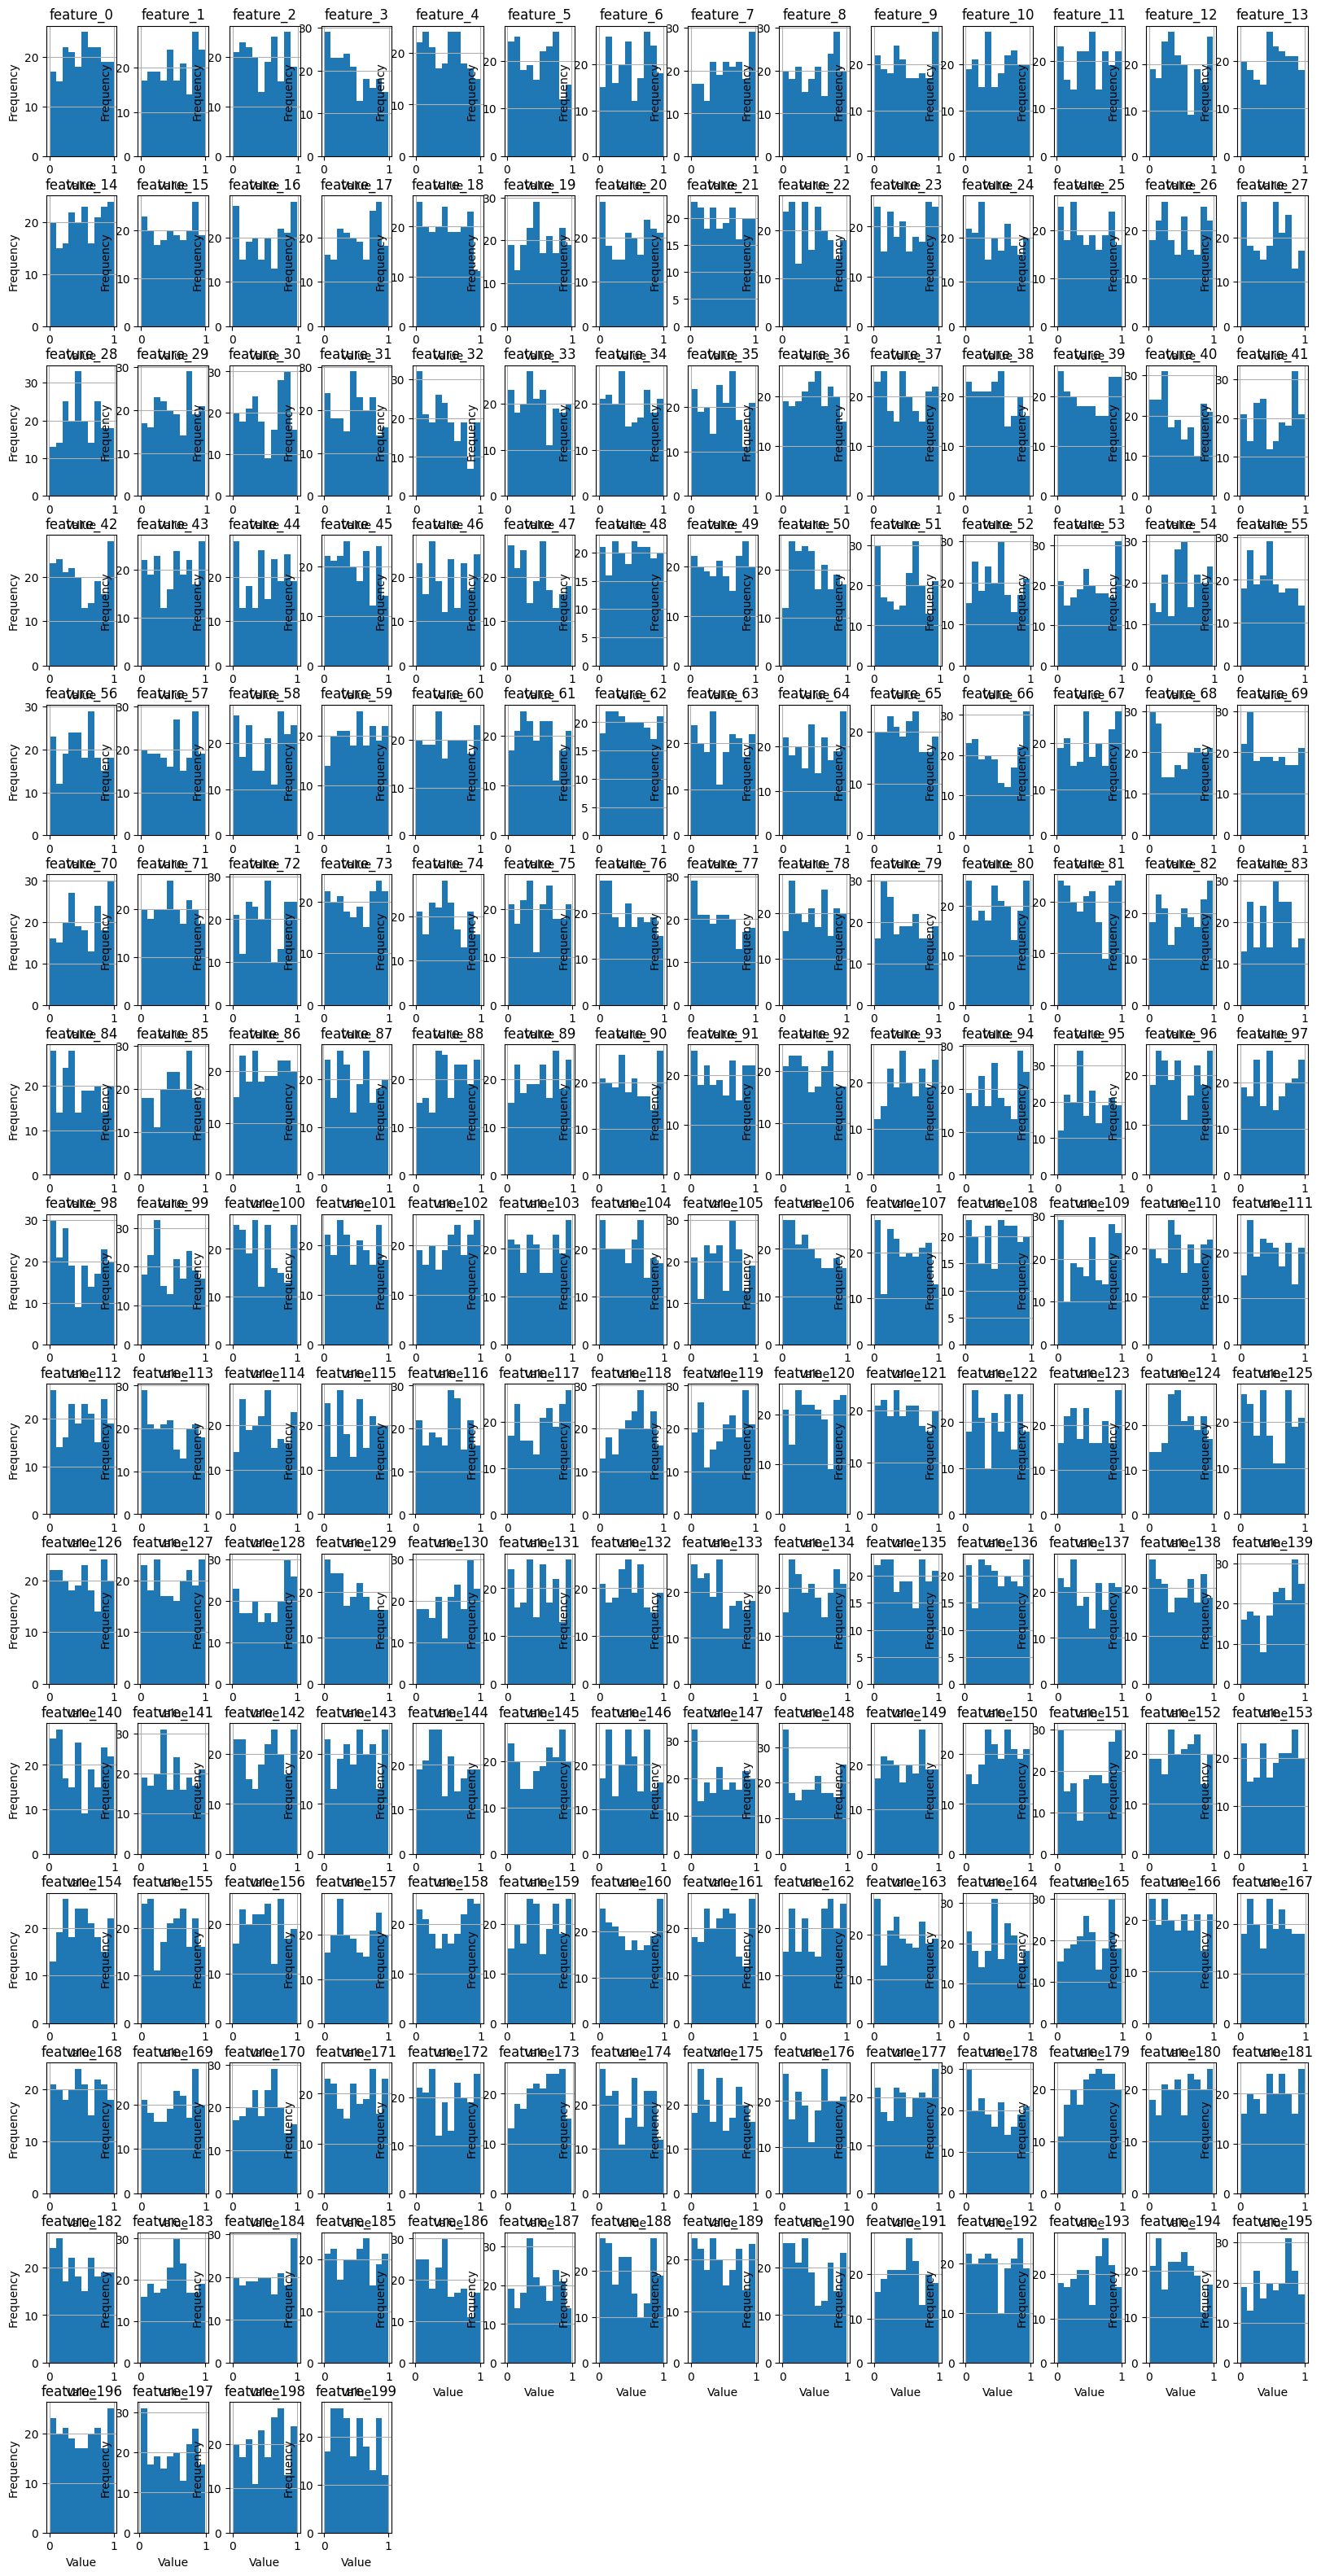

In [43]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
df = pd.DataFrame(X_train, columns=feature_names)

fig = df.hist(figsize=(20, 40))
for ax in fig.flatten():
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.show()

## Load estimators

In [117]:
estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.LinearRegression(positive=True)
)

## Train estimator

In [118]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(positive=True))])

## Evaluate

In [115]:
y_pred = estimator.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.08482385362764316
R^2 Score: 0.8847797473459287


## Cross evaluation

In [116]:
cv = sklearn.model_selection.ShuffleSplit(n_splits=5, test_size=0.5, random_state=1) 
scores = sklearn.model_selection.cross_val_score(estimator, np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test]), cv=cv, scoring="r2")
print(scores, scores.mean(), scores.std())

[0.91733127 0.89320163 0.89511909 0.91929679 0.87001218] 0.8989921924826992 0.018094037540009905


## Optimize parameters

### Create the objectives function

In [121]:
import sklearn.pipeline
import sklearn.preprocessing


def objective_base(estimator) -> float:
    estimator.fit(X_train, y_train)
    return estimator.score(X_test, y_test)


def objective_ridge(trial: optuna.trial.Trial):

    alpha = trial.suggest_float("alpha", 1e-12, 10)
    tol = trial.suggest_float("tol", 1e-12, 1e-2)
    solver = trial.suggest_categorical(
        "solver", ["auto", "svd", "cholesky", "lsqr", "sag", "saga", "lbfgs"]
    )
    positive = (
        True
        if solver == "lbfgs"
        else (
            False
            if solver != "auto"
            else trial.suggest_categorical("positive", [False, True])
        )
    )
    estimator = sklearn.linear_model.Ridge(
        alpha=alpha, solver=solver, positive=positive, tol=tol
    )

    return objective_base(estimator)


def objective_lasso(trial: optuna.trial.Trial):

    alpha = trial.suggest_float("alpha", 1e-12, 10)
    tol = trial.suggest_float("tol", 1e-12, 1e-2)
    positive = trial.suggest_categorical("positive", [False, True])

    estimator = sklearn.linear_model.Ridge(alpha=alpha, positive=positive, tol=tol)
    return objective_base(estimator)


def objective_forest(trial: optuna.trial.Trial):

    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"]
    )
    n_estimators = trial.suggest_int("n_estimators", low=1, high=1000)
    max_depth = trial.suggest_int("max_depth", low=1, high=1000)
    min_samples_split = trial.suggest_float("min_samples_split", low=0, high=1)

    estimator = sklearn.ensemble.RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
    )
    return objective_base(estimator)


def objective_sgd(trial: optuna.trial.Trial):

    losses = [
        "squared_error",
        "huber",
        "epsilon_insensitive",
        "squared_epsilon_insensitive",
    ]
    params = {
        "alpha": trial.suggest_float("alpha", 1e-12, 1e2),
        "tol" : trial.suggest_float("tol", 1e-12, 1e-2),
        "l1_ratio": trial.suggest_float("tol", 0, 1),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", None]),
        "loss": trial.suggest_categorical("solver", losses),
        "fit_intercept": trial.suggest_categorical("intercept", [True, False]),
        "epsilon" : trial.suggest_float("epsilon", 0, 1e4)
    }

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.SGDRegressor(**params)
    )
    return objective_base(estimator)


def objective_SVR(trial: optuna.trial.Trial):
    params = {
        "C" : trial.suggest_float("C", 1e-3, 1e3),
        "epsilon" : trial.suggest_loguniform("epsilon", 1e-3, 1),
        "kernel" : trial.suggest_categorical("kernem", ["linear", "poly", "rbf", "sigmoid"]),
        "degree" : trial.suggest_int("degree", 0, 5),
        "gamma" : trial.suggest_categorical("gamma", ["scale", "auto"])
    }

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.SVR(**params)
    )

    return objective_base(estimator)


def objective_boost(trial):
    # Define the hyperparameters to optimize
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
    }

    # Initialize the estimator with the hyperparameters
    estimator = sklearn.ensemble.GradientBoostingRegressor(**params, random_state=42)

    return objective_base(estimator)

### Run the expirements

In [125]:
storage_name = "regression.db"
if os.path.exists(storage_name):
    os.remove(storage_name)

study = optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Regression",
        load_if_exists=False,
        direction="maximize",  # we want to maximize the R2 score
    )
study.optimize(func=objective_ridge, n_trials=50)

[I 2024-06-30 19:29:15,885] A new study created in RDB with name: Regression
[I 2024-06-30 19:29:15,968] Trial 0 finished with value: 0.7126529228774546 and parameters: {'alpha': 0.5392188942553989, 'tol': 0.007413747532608095, 'solver': 'sag'}. Best is trial 0 with value: 0.7126529228774546.
[I 2024-06-30 19:29:16,020] Trial 1 finished with value: 0.6166059825558785 and parameters: {'alpha': 4.689951338267634, 'tol': 0.007945267479901257, 'solver': 'lsqr'}. Best is trial 0 with value: 0.7126529228774546.
[I 2024-06-30 19:29:16,090] Trial 2 finished with value: 0.6799823403971912 and parameters: {'alpha': 1.209542412198927, 'tol': 0.006527586549125231, 'solver': 'saga'}. Best is trial 0 with value: 0.7126529228774546.
[I 2024-06-30 19:29:16,143] Trial 3 finished with value: 0.6950067935410569 and parameters: {'alpha': 0.16727270170325675, 'tol': 0.005430575672309654, 'solver': 'lsqr'}. Best is trial 0 with value: 0.7126529228774546.
[I 2024-06-30 19:29:16,204] Trial 4 finished with val

### Display the best results and hyperparameters

In [126]:
print(f"Best value: {study.best_value:.4f} (params: {study.best_params})")
for key, value in study.best_trial.params.items():
    if type(value) == float:
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

Best value: 0.8818 (params: {'alpha': 0.07418654815469877, 'tol': 0.0030059778295815267, 'solver': 'auto', 'positive': True})
alpha: 0.07
tol: 0.00
solver: auto
positive: True


### See all expirements results

In [124]:
!optuna-dashboard sqlite:///regression.db

[2024-06-30 19:27:28 +0200] [117410] [INFO] Starting gunicorn 22.0.0
[2024-06-30 19:27:28 +0200] [117410] [INFO] Listening at: http://127.0.0.1:8080 (117410)
[2024-06-30 19:27:28 +0200] [117410] [INFO] Using worker: gthread
[2024-06-30 19:27:28 +0200] [117429] [INFO] Booting worker with pid: 117429
^C
[2024-06-30 19:28:50 +0200] [117410] [INFO] Handling signal: int
[2024-06-30 19:28:50 +0200] [117429] [INFO] Worker exiting (pid: 117429)


## Conclusion

**Method 1 : LinearRegression**

Analyses :
- Normalization does not improve performances : data are already beewteew 0 and 1.
- Using only LinearRegression, the paramters "positive" must be set to True. otherwise the estimator will overfit 

The Linear Regression obtains 0.88 for the R2 score on the given train and test dataset.
Moreover, cross-validation obtains an equivalent mean for the R2 score so we can conclude that the train and test dataset was not biased.  

**Method 2 : Ridge and Lasso**

These methods obtain similar result compared to LinearRegression.
However, their regularizations does not improve the performances.

The parameter "positive" must still be set to true, otherwise the estimator will overfit.
The solvers and optimizing hyperparameters have their importance : only "lbfgs" and "auto" go higher than 0.88 on the R2-score


**Other methods : Random forest, xgboost, SVR, SGD**

Even with the optimization of hyperparameters, these methods did not obtain more than 0.7 for the r2-score.